## Importing the time series and setting date time

In [1]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute
from  scipy.stats import skew, kurtosis, shapiro
import datetime


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))

consumptionLoad = pd.read_csv("D:\Onedrive\Leuven\Final project\data\consumption.csv",index_col = "meter_id")
new_index = np.arange(1,len(consumptionLoad.index)+1)
new_index = []
for i in np.arange(1,len(consumptionLoad.index)+1):
    new_index.append("meter_" + str(i))
new_index = pd.Series(new_index)
consumptionLoad.set_index(new_index,inplace=True)
consumptionLoad_T = consumptionLoad.transpose()
dates = pd.to_datetime(consumptionLoad_T.index)
consumptionLoad_T = consumptionLoad_T.set_index(dates);consumptionLoad_T.head()
consumptionLoad = consumptionLoad_T

def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))



In [2]:
def visualization_NaN(months_show,meter_show,rows = 4, columns = 3):
    if rows*columns != len(months_show):
        raise Exception("The number of months doesn't match with the amount of provided figures")
    originalMeter = pd.DataFrame(data=consumptionLoad_T[meter_show])
    originalMeter["month"] = originalMeter.index.month_name()
    originalMeter["day"] = originalMeter.index.day
    r=0
    c=0
    _, axes = plt.subplots(rows,columns)

    for m in months_show:
        originalMeter_month = originalMeter[originalMeter["month"] == m]

        index = []
        lost = []
        full = []

        for i in np.arange(originalMeter_month["day"][0],originalMeter_month["day"][-1]+1,1):
            dataDay = originalMeter_month[originalMeter_month["day"] == i]
            index.append(str(i))
            nNaN = dataDay[meter_show].isnull().sum()
            lost.append(nNaN)
            full.append(len(dataDay)-nNaN)

        df = pd.DataFrame(index=index)
        df["full"] = full
        df["lost"] = lost

        df.plot.bar(stacked=True,figsize=(30,24),ax=axes[r][c],title= m)

        if c == columns - 1:
            r += 1
            c = 0
        else:
            c += 1
    
    plt.show()

## Selecting the meters that have observations in all months.

In [3]:
data_monthly = consumptionLoad_T.resample('MS',axis=0).sum()
new_index_months = data_monthly.index.month_name()
data_monthly.set_index(new_index_months,inplace=True)
### Create an empty dataframe to store the first index of non zero value
first_non_zero_ind = pd.DataFrame(index = ['first_non_zero_row'])

In [4]:
### Create empty list to store IDs of TS to remove (because they are full of zeros/NaN only)
ID_NaN = []
### Loop through the columns and though the indexes of the dataframe
for col_ind in range(len(data_monthly.columns)):
    ID = data_monthly.columns[col_ind]
    for row_ind in range(len(data_monthly.index)):
### we check for non zero values, but only if a first value has not been selected yet 
        if (data_monthly.iloc[[row_ind],[col_ind]].values != 0) and (not ID in first_non_zero_ind.columns):
            first_non_zero_ind.insert(col_ind,ID,[row_ind]) #The value inserted indicates when the data starts
### in the case of an 'empty' TS, we place a NaN and we save the ID of this TS     
        elif ( all(val == 0 for val in data_monthly[[ID]].values) ) and (not ID in first_non_zero_ind.columns):
            first_non_zero_ind.insert(col_ind,ID,np.NaN)
            ID_NaN.append(ID)

In [5]:
print("Meter without data: {}.".format(ID_NaN))

Meter without data: ['meter_258'].


In [6]:
meters_with_full_data = first_non_zero_ind.columns[first_non_zero_ind.iloc[0] == 0]
fullYeardata = consumptionLoad_T[meters_with_full_data]

In [7]:
amount_measurements = fullYeardata.shape[0]
amount_meters = fullYeardata.shape[1]
print("The amount of measurements: {}.".format(amount_measurements))
print("The amount of meters: {}.".format(amount_meters))

The amount of measurements: 17520.
The amount of meters: 270.


## Investigating best way to subsitude the missing values

In [8]:
pct_NaN = fullYeardata.isnull().sum().sort_values().div(amount_measurements).mul(100)
print("The amount of missing data per smart meter ranges between {} % and {} %.".format(np.around(pct_NaN.min(),2),np.around(pct_NaN.max(),2)))

The amount of missing data per smart meter ranges between 1.1 % and 35.34 %.


In [9]:
data_MV = fullYeardata.copy(deep=True)
data_MV["month"] = data_MV.index.month_name()
data_MV = data_MV[data_MV["month"] == "March"]
data_MV.drop("month",axis='columns', inplace=True)
# visualization_NaN(["January","February","March","April","May","June","July","August","September","October","November","December"],"meter_3002")
print("Amount of meters with no missing days in the month March: {}.".format(len(data_MV.columns[data_MV.isnull().sum() == 0])))
col_no_missing = list(data_MV.columns[data_MV.isnull().sum() == 0])


Amount of meters with no missing days in the month March: 181.


In [31]:
reference = data_MV[col_no_missing].copy(deep=True)
test = reference.copy(deep = True)

In [32]:
# Select randomly 7 days that will be removed. 
removed_days = dict()
test["day"] = test.index.day
for col_ind in range(len(test.columns)):
    ID = test.columns[col_ind]
    rand_days = np.random.randint(2,31,size=7)
    removed_days[ID] = rand_days
    for i in rand_days:
        test.loc[test["day"] == i,ID] = np.nan
test.drop("day",axis=1,inplace = True)
print(test.isnull().sum())

meter_2979    240
meter_2981    336
meter_2983    288
meter_2986    336
meter_2988    288
             ... 
meter_3239    288
meter_3240    288
meter_3241    240
meter_3243    288
meter_3246    240
Length: 181, dtype: int64


In [33]:
part_test = test.loc[:, 'meter_2981']

In [36]:
df = pd.DataFrame(index = part_test.index, data = part_test)
print(df.isnull().sum())
print(df)
print(type(df))

meter_2981    336
dtype: int64
                     meter_2981
2017-03-01 00:00:00       0.648
2017-03-01 00:30:00       1.773
2017-03-01 01:00:00       1.733
2017-03-01 01:30:00       1.742
2017-03-01 02:00:00       1.747
...                         ...
2017-03-31 21:30:00       0.132
2017-03-31 22:00:00       0.605
2017-03-31 22:30:00       0.466
2017-03-31 23:00:00       0.052
2017-03-31 23:30:00       0.498

[1488 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [114]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 1
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[[previous_measure_index],[col_ID]].iloc[0,0]
            print("next_measure_value: %s\tprevious_measure_value: %s" % (next_measure_value, previous_measure_value))
            print(np.isnan(next_measure_value))

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                print(n)
                
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[[next_measure_index],[col_ID]].iloc[0,0]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                    

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation

# Take a measure when first or last day of the year are missing



In [115]:
estimated_mean_signal(df)

next_measure_value: nan	previous_measure_value: 0.065
True
2
next_measure_value: nan	previous_measure_value: 1.6380000000000001
True
2
next_measure_value: nan	previous_measure_value: 0.47200000000000003
True
2
next_measure_value: nan	previous_measure_value: 0.358
True
2
next_measure_value: nan	previous_measure_value: 0.306
True
2
next_measure_value: nan	previous_measure_value: 0.068
True
2
next_measure_value: nan	previous_measure_value: 1.1520000000000001
True
2
next_measure_value: nan	previous_measure_value: 1.548
True
2
next_measure_value: nan	previous_measure_value: 0.855
True
2
next_measure_value: nan	previous_measure_value: 0.027000000000000003
True
2
next_measure_value: nan	previous_measure_value: 0.040999999999999995
True
2
next_measure_value: nan	previous_measure_value: 0.242
True
2
next_measure_value: nan	previous_measure_value: 0.027000000000000003
True
2
next_measure_value: nan	previous_measure_value: 0.045
True
2
next_measure_value: nan	previous_measure_value: 0.055
True
2


In [116]:
print(df.loc['2017-03-26':'2017-03-28'])



                     meter_2981
2017-03-26 00:00:00    0.062000
2017-03-26 00:30:00    1.620000
2017-03-26 01:00:00    1.035000
2017-03-26 01:30:00    0.995000
2017-03-26 02:00:00    0.317500
...                         ...
2017-03-28 21:30:00    0.322125
2017-03-28 22:00:00    0.393500
2017-03-28 22:30:00    0.123750
2017-03-28 23:00:00    0.344000
2017-03-28 23:30:00    0.123875

[144 rows x 1 columns]


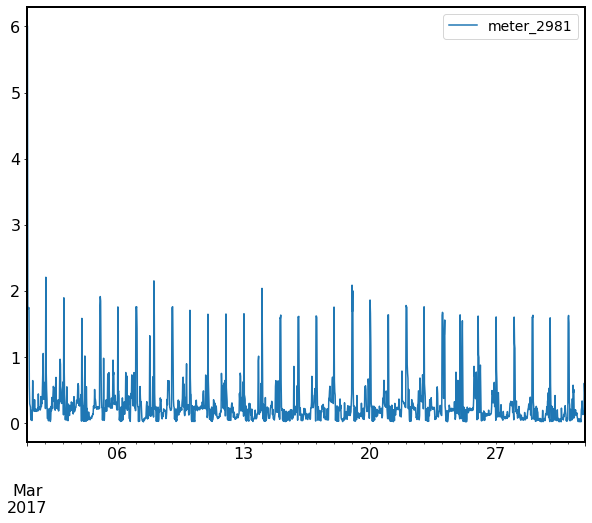

In [117]:
df.plot()

In [46]:
import datetime
time_stamp = pd.Timestamp('2017-02-28')
# print(missing_index[3])
# missing_index[3] + datetime.timedelta(days=1)
n=1
time_stamp + datetime.timedelta(days=-n)

Timestamp('2017-02-27 00:00:00')

In [113]:
def calculate_mean_of_2days(day1, day2,ID, data):
    data["days"] = data.index.day
    TS1 = np.squeeze(data.loc[data["days"] == day1,ID])
    TS1 = TS1.reset_index()
    TS2 = np.squeeze(data.loc[data["days"] == day2,ID])
    TS2 = TS2.reset_index()
    print(TS1)
    print(TS2)
    return TS1.add(TS2)

In [114]:
# Look in the timeserie for the previous and the next day and calculate the average --> estimation for the missing day.
for item in removed_days.items():
    ID = item[0]
    days = item[1]
    for i in days:
        # Check if the days before and after are empty
        if not(i + 1 in days or i - 1 in days):
        #Calculate the mean
            mean = calculate_mean_of_2days(str(i+1),str(i-1),ID,test)
            test.loc[test["day"] == i,ID] = mean
        else:
            n1 = 1
            n2 = 2
            while(True): 
                if not(i+n1*1 in days and i-n2*1 in days):
                    day1 = i+n1*1; day2 = i-n2*1
                    mean = calculate_mean_of_2days(str(day1),str(day2),ID,test)
                    for j in np.arange(day1,day2,1):
                            test.loc[test["day"] == j,ID] = mean
                    break
                elif not(i+n2*1 in days and i-n1*1 in days):
                    day1 = i+n2*1; day2 = i-n1*1
                    mean = calculate_mean_of_2days(str(day1),str(day2),ID,test)
                    for j in np.arange(day1,day2,1):
                            test.loc[test["day"] == j,ID] = mean
                    break
                elif not(i+n2*1 in days and i-n2*1 in days):
                    day1 = i+n2*1; day2 = i-n2*1
                    mean = calculate_mean_of_2days(str(day1),str(day2),ID,test)
                    for j in np.arange(day1,day2,1):
                            test.loc[test["day"] == j,ID] = mean
                    break
                n1 += 1
                n2 += 1

    

Empty DataFrame
Columns: [index, meter_2979]
Index: []
Empty DataFrame
Columns: [index, meter_2979]
Index: []


TypeError: cannot add DatetimeArray and DatetimeArray

In [89]:
#Calculate the error made due to the estimation --> mse


In [100]:
np.squeeze(test.loc[:,["meter_2979"]])

2017-03-01 00:00:00    0.084
2017-03-01 00:30:00    0.146
2017-03-01 01:00:00    0.083
2017-03-01 01:30:00    0.121
2017-03-01 02:00:00    0.144
                       ...  
2017-03-31 21:30:00    0.099
2017-03-31 22:00:00    0.147
2017-03-31 22:30:00    0.114
2017-03-31 23:00:00    0.125
2017-03-31 23:30:00    0.100
Name: meter_2979, Length: 1488, dtype: float64